/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to UserParams are not supported: ['F_ESC10', 'ALPHA_ESC']
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/inputs.py:491: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can

Box: 200 Mpc, 64^3 (Δx=3.12 Mpc) 
zs = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0]
Running diagnostic: z=16.0, F_ESC10=1.0, ALPHA_ESC=-1.0 ...


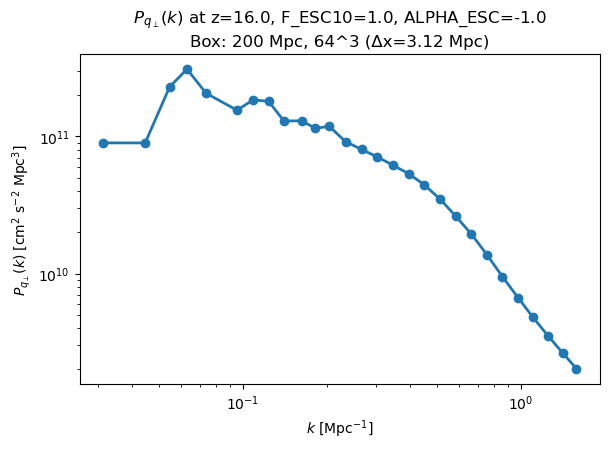

Running diagnostic: z=16.0, F_ESC10=1.0, ALPHA_ESC=-0.5 ...


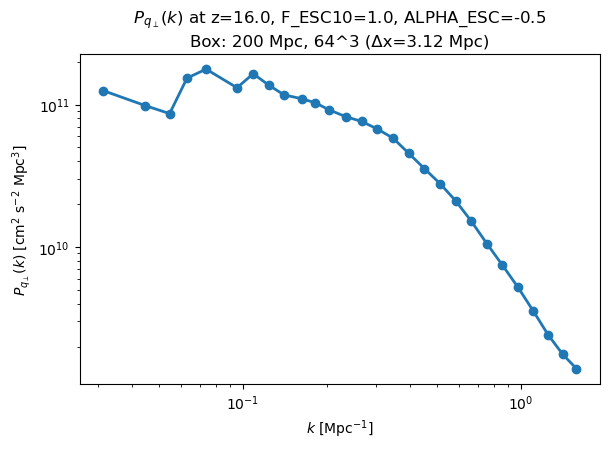

Running diagnostic: z=16.0, F_ESC10=1.0, ALPHA_ESC=0.0 ...


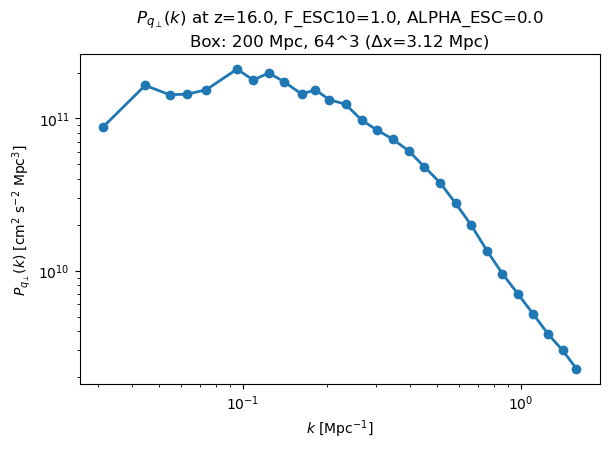

Running diagnostic: z=16.0, F_ESC10=1.0, ALPHA_ESC=0.5 ...


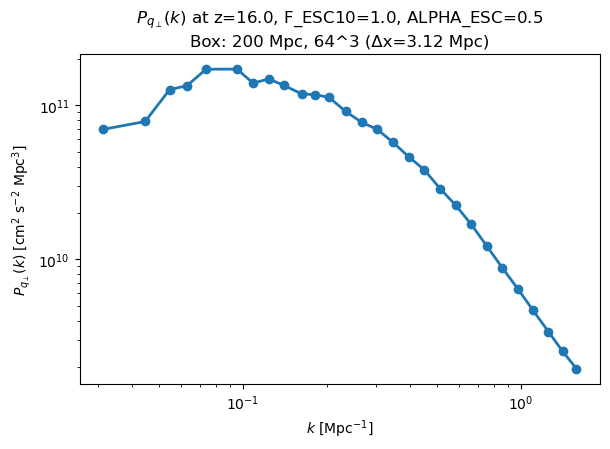

Processing ALPHA_ESC = -1.0 ...
  D_3000 (μK^2) ≈ 3.318e-27
Processing ALPHA_ESC = -0.5 ...
  D_3000 (μK^2) ≈ 2.937e-27
Processing ALPHA_ESC = 0.0 ...
  D_3000 (μK^2) ≈ 2.987e-27
Processing ALPHA_ESC = 0.5 ...
  D_3000 (μK^2) ≈ 2.804e-27


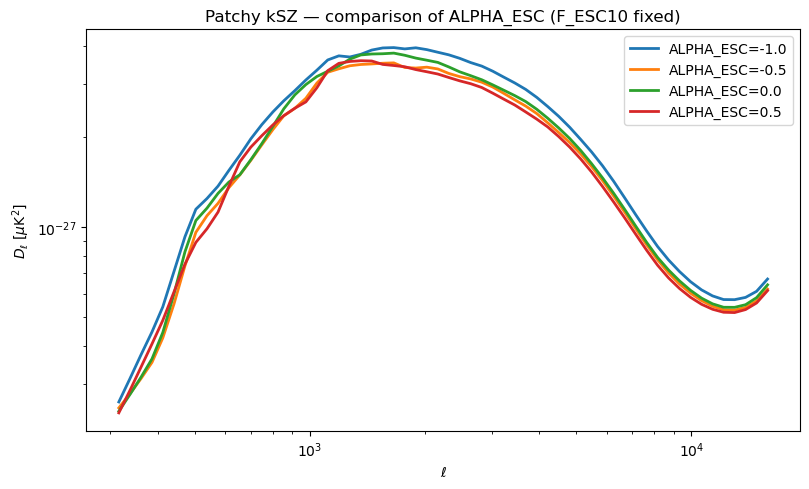

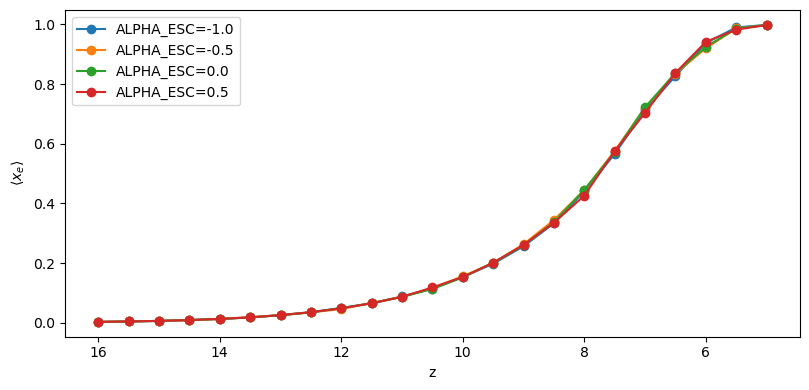

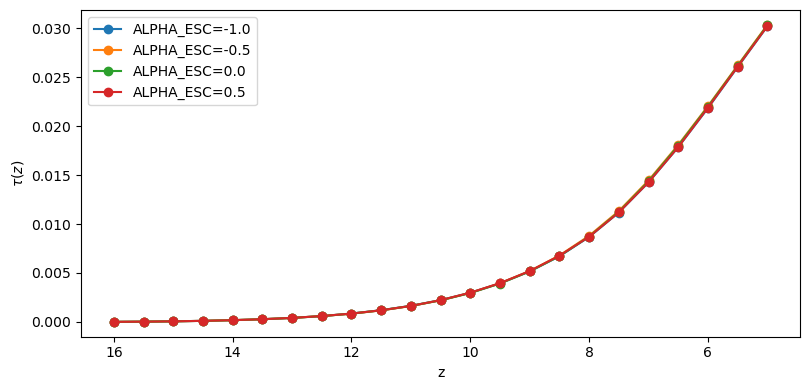

Done. Cached per-(z,alpha) P(k) arrays in /home/swanith/Desktop/Project2/Plots/alpha_esc_vary/pk_alpha_cache


In [1]:
#!/usr/bin/env python
# coding: utf-8

# Pipeline: fix F_ESC10 and sweep ALPHA_ESC
# Adapted from your earlier notebook/script. Keeps all internals identical
# except we hold F_ESC10 fixed (e.g. 1.0) and vary ALPHA_ESC.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

try:
    import py21cmfast as p21
except Exception as e:
    raise RuntimeError("py21cmfast is required for these plots.") from e

# physical constants
sigma_T = const.sigma_T.cgs.value
MPC_CM = 3.0856775814913673e24

# box / resolution
HII_DIM = 64
BOX_LEN = 200.0
ZS = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0]
voxel = BOX_LEN / HII_DIM
BOX_LABEL = f"Box: {BOX_LEN:.0f} Mpc, {HII_DIM}^3 (\u0394x={voxel:.2f} Mpc)"
print(BOX_LABEL, "\nzs =", ZS)

# mean electron density helper
def ne0_cgs(Y_He=0.24, include_He=True):
    m_p = const.m_p.cgs.value
    rho_c0 = cosmo.critical_density0.cgs.value
    Om_b = cosmo.Ob0
    n_b0 = (Om_b * rho_c0) / m_p
    X_H = 1.0 - Y_He
    n_H0 = X_H * n_b0
    if include_He:
        y = Y_He / (4.0 * X_H)
        electrons_per_H = 1.0 + y
    else:
        electrons_per_H = 1.0
    return n_H0 * electrons_per_H

ne0 = ne0_cgs()

# run coeval wrapper (accepts user_overrides forwarded to p21.run_coeval)
def run_coeval_fields(z, HII_DIM=HII_DIM, BOX_LEN=BOX_LEN, user_overrides=None):
    user_params = {"HII_DIM": int(HII_DIM), "BOX_LEN": float(BOX_LEN)}
    if user_overrides:
        user_params.update(user_overrides)

    coeval = p21.run_coeval(redshift=float(z), user_params=user_params, write=False)
    delta = coeval.density
    xH = coeval.xH_box
    chi = 1.0 - xH
    vx = coeval.lowres_vx * 1e5
    vy = coeval.lowres_vy * 1e5
    vz = coeval.lowres_vz * 1e5
    return delta, chi, vx, vy, vz

# helpers
def build_momentum(delta, chi, vx, vy, vz):
    ne_fluct = (1.0 + delta) * chi
    return ne_fluct * vx, ne_fluct * vy, ne_fluct * vz

def central_slice(arr):
    N = arr.shape[0]
    return arr[N//2, :, :]

# q_perp FFT and power (unchanged logic)
def qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None, M_TURN=None):
    ne_fluct = (1.0 + delta) * chi
    qx = ne_fluct * vx
    qy = ne_fluct * vy
    qz = ne_fluct * vz
    N = qx.shape[0]
    L = float(BOX_LEN)
    d = L / N
    V = L**3
    kfreq = np.fft.fftfreq(N, d=d) * 2.0*np.pi
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    k2 = kx*kx + ky*ky + kz*kz
    k = np.sqrt(k2)
    k2_safe = np.where(k2 == 0.0, np.inf, k2)

    Qx = np.fft.fftn(qx) * (d**3)
    Qy = np.fft.fftn(qy) * (d**3)
    Qz = np.fft.fftn(qz) * (d**3)

    kdotQ_over_k2 = (Qx*kx + Qy*ky + Qz*kz) / k2_safe
    Qx_perp = Qx - kdotQ_over_k2 * kx
    Qy_perp = Qy - kdotQ_over_k2 * ky
    Qz_perp = Qz - kdotQ_over_k2 * kz

    Qperp2 = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)
    p_flat = (Qperp2 / V).ravel()
    k_flat = k.ravel()

    if nbins is None:
        nbins = int(np.ceil(np.cbrt(N) * 8))
    nbins = max(2, int(nbins))

    unique_kfreqs = np.unique(np.abs(kfreq))
    pos_kfreqs = unique_kfreqs[unique_kfreqs > 0.0]
    if pos_kfreqs.size == 0:
        kmin = 1e-6
    else:
        kmin = pos_kfreqs.min()
    kmax = np.abs(kfreq).max() * np.sqrt(3.0)
    if kmax <= kmin:
        kmax = kmin * 10.0

    bins = np.geomspace(kmin, kmax, nbins)
    digit = np.digitize(k_flat, bins)

    kvals, pvals, counts = [], [], []
    for i in range(1, len(bins)):
        mask = digit == i
        if not np.any(mask):
            continue
        kvals.append(k_flat[mask].mean())
        pvals.append(p_flat[mask].mean())
        counts.append(int(mask.sum()))

    qx_perp_r = np.fft.ifftn(Qx_perp) / (d**3)
    qy_perp_r = np.fft.ifftn(Qy_perp) / (d**3)
    qz_perp_r = np.fft.ifftn(Qz_perp) / (d**3)
    qperp_mag = np.sqrt(np.abs(qx_perp_r)**2 + np.abs(qy_perp_r)**2 + np.abs(qz_perp_r)**2).real
    qperp_slice = qperp_mag[N//2, :, :]

    plane_Q = (np.abs(Qx)**2 + np.abs(Qy)**2 + np.abs(Qz)**2)**0.5
    plane_Qperp = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)**0.5
    kplane_amp = np.fft.fftshift(plane_Q[:, :, N//2])
    kplane_amp_perp = np.fft.fftshift(plane_Qperp[:, :, N//2])
    kx2 = np.fft.fftshift(kx[:, :, N//2])
    ky2 = np.fft.fftshift(ky[:, :, N//2])

    return (np.array(kvals), np.array(pvals), qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, M_TURN)

# ------------------
# User choices: fix F_ESC10, sweep ALPHA_ESC
# ------------------
F_ESC10_fixed = 1.0
ALPHA_ESC_values = [-1.0, -0.5, 0.0, 0.5]

# small diagnostic loop example (similar to your cell 5b)
z_show = 16.0
for a in ALPHA_ESC_values:
    print(f"Running diagnostic: z={z_show}, F_ESC10={F_ESC10_fixed}, ALPHA_ESC={a} ...")
    delta, chi, vx, vy, vz = run_coeval_fields(z_show, user_overrides={"F_ESC10": F_ESC10_fixed, "ALPHA_ESC": float(a)})
    kvals, Pbins, qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, _ = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN)

    # plot P(k)
    plt.figure(figsize=(6.2,4.6))
    plt.loglog(kvals, Pbins, lw=2, marker='o')
    plt.xlabel(r"$k$ [Mpc$^{-1}$]")
    plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
    plt.title(f"$P_{{q_\perp}}(k)$ at z={z_show}, F_ESC10={F_ESC10_fixed}, ALPHA_ESC={a}\n{BOX_LABEL}")
    plt.tight_layout(); plt.show()

# ------------------
# Full pipeline: compute P(k) over (z,alpha), cache, then build kSZ D_ell curves for each alpha
# ------------------
from pathlib import Path
from scipy.interpolate import interp1d
cache_dir = Path('pk_alpha_cache')
cache_dir.mkdir(exist_ok=True)

# helper: alpha label/fragment for filenames
def alabel_and_frag(a):
    frag = str(a).replace('-', 'm').replace('.', 'p')
    label = f"{a:.2f}"
    return label, frag

# compute or load per-(z,alpha) P(k) and mean x_e
def compute_or_load_pk(z, a, force=False):
    label, frag = alabel_and_frag(a)
    fname = cache_dir / f"pk_z{z}_alpha_{frag}.npz"
    if fname.exists() and not force:
        dat = np.load(fname)
        return dat['k'], dat['P'], float(dat.get('xe_mean', np.nan))
    delta, chi, vx, vy, vz = run_coeval_fields(z, user_overrides={"F_ESC10": F_ESC10_fixed, "ALPHA_ESC": float(a)})
    xe_mean = float(chi.mean())
    kbins, Pbins, *_ = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN)
    np.savez(fname, k=kbins, P=Pbins, xe_mean=xe_mean)
    return kbins, Pbins, xe_mean

# geometry prep
ZS_run = np.array(ZS, dtype=float)
zsort_desc = np.argsort(-ZS_run)
chis = np.array([cosmo.comoving_distance(z).value for z in ZS_run])
a_z = 1.0/(1.0 + ZS_run)
ZS_sorted = ZS_run[zsort_desc]
chi_sorted = chis[zsort_desc]
a_sorted = a_z[zsort_desc]
dchi_sorted = np.empty_like(chi_sorted)
dchi_sorted[:-1] = np.diff(chi_sorted)
dchi_sorted[-1] = dchi_sorted[-2] if len(dchi_sorted)>1 else 0.0
dchi_sorted = np.abs(dchi_sorted)

# ell grid
ells = np.unique(np.round(np.logspace(2.5, 4.2, 60))).astype(int)

# prefactor
c_cms = const.c.cgs.value
pref = (sigma_T * ne0 / c_cms)**2

# containers
Dell_by_alpha = {}
xe_by_alpha = {}
tau_by_alpha = {}

for a in ALPHA_ESC_values:
    print(f"Processing ALPHA_ESC = {a} ...")
    k_list = []
    P_list = []
    xe_means = []
    for z in ZS_sorted:
        kb, Pb, xe_mean = compute_or_load_pk(z, a)
        k_list.append(np.asarray(kb))
        P_list.append(np.asarray(Pb))
        xe_means.append(float(xe_mean))
    xe_sorted = np.array(xe_means)
    xe_by_alpha[str(a)] = (ZS_sorted.copy(), xe_sorted.copy())

    # tau
    tau = np.zeros_like(ZS_sorted, dtype=float)
    running = 0.0
    for i in range(len(ZS_sorted)-1):
        zmid = 0.5*(ZS_sorted[i] + ZS_sorted[i+1])
        a_mid = 1.0/(1.0 + zmid)
        xe_mid = 0.5*(xe_sorted[i] + xe_sorted[i+1])
        dtaus = sigma_T * ne0 * xe_mid * (a_mid**-2) * (dchi_sorted[i] * MPC_CM)
        running += dtaus
        tau[i+1] = running
    tau_by_alpha[str(a)] = (ZS_sorted.copy(), tau.copy())

    # accumulate C_ell
    vis2_sorted = np.exp(-2.0 * tau)
    C_ell = np.zeros_like(ells, dtype=float)
    for i in range(len(ZS_sorted)):
        s = chi_sorted[i]
        a_now = a_sorted[i]
        w = vis2_sorted[i] / (s**2 * a_now**4) * (dchi_sorted[i] * MPC_CM)
        k_now = ells / s
        # log-log interpolation
        xp = k_list[i]; fp = P_list[i]
        mask = (xp > 0) & (fp > 0)
        if mask.sum() < 2:
            P_now = np.zeros_like(k_now)
        else:
            f_interp = interp1d(np.log(xp[mask]), np.log(fp[mask]), bounds_error=False, fill_value=(np.nan, np.nan))
            P_now = np.exp(f_interp(np.log(np.clip(k_now, xp[mask].min(), xp[mask].max()))))
        C_ell += pref * w * P_now

    D_ell_uK2 = ells*(ells+1.0)/(2.0*np.pi) * C_ell * (2.7255**2) * (1e6**2)
    Dell_by_alpha[str(a)] = (ells.copy(), D_ell_uK2.copy())
    D3000 = float(np.interp(3000.0, ells, D_ell_uK2))
    print(f"  D_3000 (\u03bcK^2) ≈ {D3000:.4g}")

# plotting
plt.figure(figsize=(8.2,5.0))
for a in ALPHA_ESC_values:
    ells_plot, Dplot = Dell_by_alpha[str(a)]
    plt.loglog(ells_plot, Dplot, lw=2, label=f"ALPHA_ESC={a}")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$ [$\mu$K$^2$]")
plt.title("Patchy kSZ — comparison of ALPHA_ESC (F_ESC10 fixed)")
plt.legend(); plt.tight_layout(); plt.savefig("Alpha_esc_vary"); plt.show()

# xe(z) and tau(z)
plt.figure(figsize=(8.2,4.0))
for a in ALPHA_ESC_values:
    zs_plot, xe_plot = xe_by_alpha[str(a)]
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], xe_plot[order_plot], marker='o', label=f"ALPHA_ESC={a}")
plt.xlabel('z'); plt.ylabel(r"$\langle x_e \rangle$"); plt.gca().invert_xaxis(); plt.legend(); plt.tight_layout(); plt.savefig("xe_alpha_vary"); plt.show()

plt.figure(figsize=(8.2,4.0))
for a in ALPHA_ESC_values:
    zs_plot, tau_plot = tau_by_alpha[str(a)]
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], tau_plot[order_plot], marker='o', label=f"ALPHA_ESC={a}")
plt.xlabel('z'); plt.ylabel(r"$\tau(z)$"); plt.gca().invert_xaxis(); plt.legend(); plt.tight_layout(); plt.savefig("tau_alpha_vary"); plt.show()

print('Done. Cached per-(z,alpha) P(k) arrays in', cache_dir.resolve())
